# Practice Session 03: Find near-duplicates using shingling

<font size="+2" color="blue">Additional results: various ngram sizes</font>

Author: <font color="blue">Luca Franceschi</font>

E-mail: <font color="blue">luca.franceschi01@estudiant.upf.edu</font>

Date: <font color="blue">18/10/2024</font>

In [52]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from unidecode import unidecode
import itertools

import datetime

In [83]:
# KEEP AS-IS

# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []

# IMPORTANT:
# 1. Set this to 1000 during development
# 2. Set this to 10000 once you have completed the development, and answer part 5 with 10000
# 3. Set this back to 1000 for delivering your code
MAX_MESSAGES = 1000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 1000 documents


# 1. Auxiliary functions

<font size="+1" color="red">Replace this cell with your code for function "jaccard_similarity"</font>

In [58]:
def jaccard_similarity(v1: tuple, v2: tuple):
    s1 = set(v1)
    s2 = set(v2)
    return len(s1.intersection(s2)) / max(1, len(s1.union(s2))) # this max really only applies when both are empty

<font size="+1" color="red">Replace this cell with your code testing "jaccard_similarity"</font>

In [59]:
examples = [
    [[1, 2], [1]],
    [[1, 2, 3, 4], [1, 2, 3]],
    [[], []],
    [[1, 2], [1, 2]],
]

for l1, l2 in examples:
    print(f'Jaccard similariry of {l1} and {l2} is {jaccard_similarity(l1, l2)}')

Jaccard similariry of [1, 2] and [1] is 0.5
Jaccard similariry of [1, 2, 3, 4] and [1, 2, 3] is 0.75
Jaccard similariry of [] and [] is 0.0
Jaccard similariry of [1, 2] and [1, 2] is 1.0


<font size="+1" color="red">Replace this cell with your code for function "clean"</font>

In [60]:
def clean(txt: str, mode:str=''):
    '''
    On normal mode it outputs the last version (fully cleaned) string.

    On testing mode it outputs all the versions of the string and all the changes done to it so
    we can test if it is performing well.
    '''
    versions = [txt]

    # 1. Removing "RT " prefixes
    versions.append(re.sub(r'^RT ', '', txt))

    # 2. Converting to lowercase
    versions.append(versions[-1].lower())

    # 3. Romanizing text, replacing "Ñ" by "n", "ñ" by "n", "ó" by "o", "à" by "a", and so on
    versions.append(unidecode(versions[-1]))

    # 4 "l·l" by "ll" (which is not done with unidecode by default)
    versions.append(re.sub(r'l\*l', 'll', versions[-1]))

    # 5. Removing URLs, both "http" and "https" ones.
    versions.append(re.sub(r'https?:\/\/[\S]*', '', versions[-1]))

    # 6. Removing anything that remains that is not a letter or digit
    versions.append(re.sub(r'[^a-zA-Z0-9 ]', ' ', versions[-1]))

    # 7. Changing double spaces to single spaces.
    versions.append(re.sub(r' +', ' ', versions[-1]))

    # 8. Removing spaces at the beginning and spaces at the end with the `strip()` function.
    versions.append(versions[-1].strip())

    if mode == 'testing':
        # Which changes did this function perform
        changes = []
        for i in range(len(versions)-1):
            if versions[i] != versions[i+1]:
                changes.append(i+1)

        return versions, set(changes)
    
    return versions[-1]

<font size="+1" color="red">Replace this cell with your code testing function "clean"</font>

In [61]:
# Prepare first iteration
i=0
msg = messages[i]
all_changes = set(range(1,9))
txt_changes = set()

while txt_changes != all_changes:
    # Perform current iteration
    txt_cleaned, tmp = clean(msg, 'testing')
    print(i, tmp, txt_cleaned[-1])

    # Prepare next iteration
    txt_changes = txt_changes.union(tmp)
    i += 1
    msg = messages[i]

0 {1, 2, 3, 6, 7, 8} aramateix la gestio del telefon d atencio 061 depen de ferrovial la decisio del govern no modifica aixo la gent no pagara de manera
1 {1, 2, 3, 6, 7, 8} totbadalona els restaurants han de reduir el seu aforament en un 66 per garantir la seguretat davant del coronavirus badalona https
2 {1, 2, 3, 5, 6, 7, 8} xsalaimartin fa temps que sabem que aquest tal garcia page es un miserable pero amb aixo se supera fins i tot a si mateix
3 {1, 2, 3, 6, 7, 8} marctarinmarti 2 la transmissio de la covid19 es per gotes per tant rao de mes de recloure s a casa si presenteu tos febre mucos
4 {1, 2, 3, 6, 7, 8} macanadell heu vist algun ministre danes corea italia o xines plorant en roda de premsa pel covid19 no perque els ministres no
5 {1, 2, 3, 6, 7, 8} angeliufus test covid19 a tota la poblacio ja i aillament som a dies de 2248 casos i q morin 150 pers al dia com ahir a italia acc
6 {1, 2, 3, 6, 7, 8} fincasantamarga sou uns irresponsables i uns fanatics en uns moments aixi i n

In [62]:
# We see in the above loop that text 23 has all the modifications so let's check that out
clean(messages[23], 'testing')

(['RT @elnacionalcat: Àustria cancel·la els vols amb Espanya, França i Suïssa pel coronavirus https://t.co/zrLwT24otX',
  '@elnacionalcat: Àustria cancel·la els vols amb Espanya, França i Suïssa pel coronavirus https://t.co/zrLwT24otX',
  '@elnacionalcat: àustria cancel·la els vols amb espanya, frança i suïssa pel coronavirus https://t.co/zrlwt24otx',
  '@elnacionalcat: austria cancel*la els vols amb espanya, franca i suissa pel coronavirus https://t.co/zrlwt24otx',
  '@elnacionalcat: austria cancella els vols amb espanya, franca i suissa pel coronavirus https://t.co/zrlwt24otx',
  '@elnacionalcat: austria cancella els vols amb espanya, franca i suissa pel coronavirus ',
  ' elnacionalcat  austria cancella els vols amb espanya  franca i suissa pel coronavirus ',
  ' elnacionalcat austria cancella els vols amb espanya franca i suissa pel coronavirus ',
  'elnacionalcat austria cancella els vols amb espanya franca i suissa pel coronavirus'],
 {1, 2, 3, 4, 5, 6, 7, 8})

# 2. Implement an n-gram extractor

<font size="+1" color="red">Replace this cell with your code implementing function "ngrams(text,size)"</font>

In [63]:
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []

    # First we remove the tokens that have length smaller than MIN_TOKEN_LENGTH
    tokens = [tok for tok in tokens if len(tok) >= MIN_TOKEN_LENGTH]

    # Then we calculate the ngrams
    for i in range(len(tokens)-(size-1)):
        ngrams.append(tokens[i:i+size])

    # Make ngrams a string again
    return [' '.join(ngram) for ngram in ngrams]

<font size="+1" color="red">Replace this cell with your code testing function "ngrams"</font>

In [64]:
print(messages[990])
print(ngrams(messages[990], 3))

Clam per la suspensió dels desnonaments en plena crisi pel coronavirus https://t.co/0g1AtSELwl
['clam per suspensio', 'per suspensio dels', 'suspensio dels desnonaments', 'dels desnonaments plena', 'desnonaments plena crisi', 'plena crisi pel', 'crisi pel coronavirus']


# 3. Estimation of brute force all-pairs method

In [65]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

<font size="+1" color="red">Replace this cell with your code for generating the requested plot. Remember to add a title and label for the x and y axis.</font>

In [84]:
times = [range(0, len(messages)+1, 200), []]
for i in times[0]:
    times[1].append(time_brute_force_similarities(messages, i, 5))

In [85]:
def estimate(x):
    times_2 = np.array(times[0])**2
    return x**2/np.max(times_2)*times[1][-1] # Normalizes according to longest time in list of times

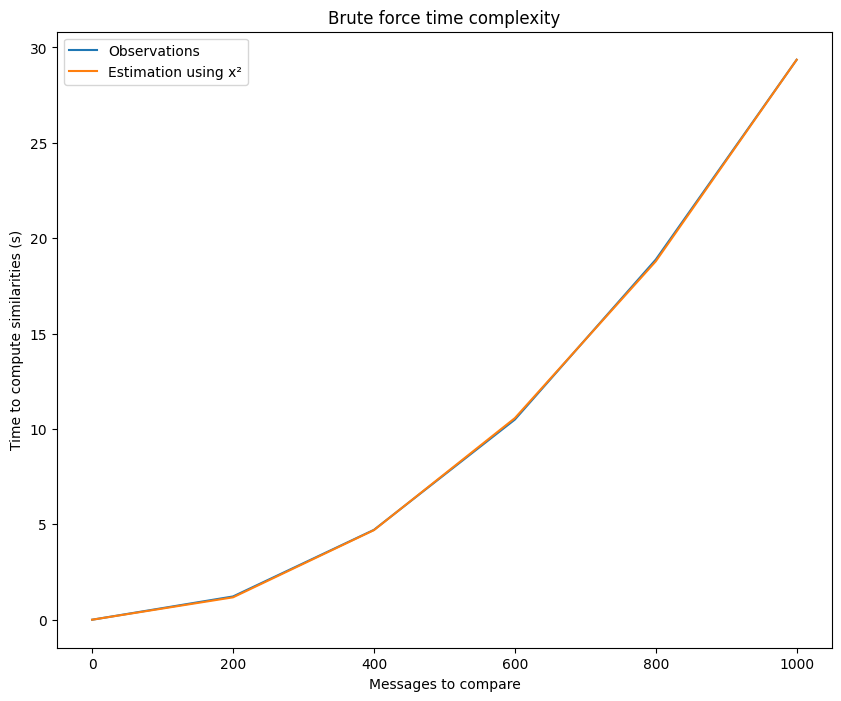

In [86]:
fig = plt.figure(figsize=(10, 8))
plt.title('Brute force time complexity')
plt.xlabel('Messages to compare')
plt.ylabel('Time to compute similarities (s)')
plt.plot(times[0], times[1], label='Observations')
x = np.array(times[0])
plt.plot(x, estimate(x), label='Estimation using x²')
plt.legend()
plt.show()

<font size="+1" color="red">Replace this cell with (1) a brief commmentary about what you see in this plot, and (2) your estimate for how long it would take to run the brute force similarity computations for the entire input matrix. Express your estimation in hours, minutes, and seconds. Justify precisely your calculations.</font>

By logic, comparing all the elements of two sets should be of time complexity O(n²). We can see that reflexted in the code, where we are using a nested for loop. If we try to fit a similar function to the graph and normalize it to the scale of the plot, we see that it matches almost perfectly. If we use that same function to compute how much time will it take to compare the entire input matrix (in the CovidLockdownCatalonia file there are 35.500 elements), we obtain the following:

In [67]:
time = datetime.timedelta(seconds=estimate(35500))
hours, remainder = divmod(time, datetime.timedelta(hours=1))
minutes, remainder = divmod(remainder, datetime.timedelta(minutes=1))
seconds = remainder / datetime.timedelta(seconds=1)

print('It will take about {} hours, {} minuntes and {:.1f} seconds ({})'.format(hours, minutes, seconds, (str(time))))

It will take about 0 hours, 0 minuntes and 15.1 seconds (0:00:15.141633)


However, it might be even longer if the data that we are handling does exceed the capacities of our setup (e.g.: does not fit in RAM and has to be swapped to disk to be managed).

# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

<font size="+1" color="red">Replace this cell with your code for creating the ngram_to_index dictionary.</font>

In [68]:
NGRAM_SIZE = 4

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram not in ngram_to_index:
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index += 1
            
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 55193 distinct ngrams in the 10000 documents


<font size="+1" color="red">Replace this cell with your code for testing the ngram_to_index structure.</font>

In [69]:
test = ['els restaurants han reduir', 'supera fins tot mateix']
max_len = max([len(t) for t in test])

for t in test:
    idx = ngram_to_index[t]
    t2 = index_to_ngram[idx]
    print(f'(SUCCESS={t==t2}) ngram_to_index[{'\''+t+'\'':{max_len+2}}] = {idx}\tindex_to_ngram[{idx:^4}]=\'{t2}\'')

(SUCCESS=True) ngram_to_index['els restaurants han reduir'] = 14	index_to_ngram[ 14 ]='els restaurants han reduir'
(SUCCESS=True) ngram_to_index['supera fins tot mateix'    ] = 38	index_to_ngram[ 38 ]='supera fins tot mateix'


## 4.2 Create table ngrams x documents

In [70]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 55193 rows (distinct shingles) x 10000 columns (distinct documents)


<font size="+1" color="red">Replace this cell with your code for filling the M_ngram_doc matrix.</font>

In [71]:
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        M_ngram_doc[ngram_to_index[ngram]][docid] = True

<font size="+1" color="red">Replace this cell with your code for printing the density of the M_ngram_doc matrix as a percentage. Use 4 decimals.</font>

In [72]:
print('The density of the M_ngram_doc matrix is {:.4%}'.format(M_ngram_doc.sum()/M_ngram_doc.size))

The density of the M_ngram_doc matrix is 0.0204%


<font size="+1" color="red">Replace this cell with your code for printing rows 9602 and 941 of the M_ngram_doc matrix.</font>

In [73]:
test = [962, 941]
for t in test:
    clean_str = clean(messages[t])
    nonz = M_ngram_doc[:,t].nonzero()[0]
    test_ngrams = [index_to_ngram[i] for i in nonz]
    print(f'{'-'*90}\nPositions of non-zeros in column of docid {t} of M_ngram_doc\n')
    print(f'Clean text:\n{clean_str}\n')
    print('Non-zeros in corresponding row:')
    for i, ngr in zip(nonz, test_ngrams):
        print(f'{i:^4} ({ngr})')

------------------------------------------------------------------------------------------
Positions of non-zeros in column of docid 962 of M_ngram_doc

Clean text:
el coronavirus tambe ensenya el cami independencia socialisme paisos catalans

Non-zeros in corresponding row:
7956 (coronavirus tambe ensenya cami)
7957 (tambe ensenya cami independencia)
7958 (ensenya cami independencia socialisme)
7959 (cami independencia socialisme paisos)
7960 (independencia socialisme paisos catalans)
------------------------------------------------------------------------------------------
Positions of non-zeros in column of docid 941 of M_ngram_doc

Clean text:
hospiolot usem de forma responsable els recursos sanitaris 061 urgencies per coronavirus i sanitaries 012 consultes general

Non-zeros in corresponding row:
1083 (usem forma responsable els)
1084 (forma responsable els recursos)
1085 (responsable els recursos sanitaris)
1086 (els recursos sanitaris 061)
1087 (recursos sanitaris 061 urgencies)

# 5. Implement a permutation generator

<font size="+1" color="red">Replace this cell with your code for "random_permutation"</font>

In [74]:
def random_permutation(k: int):
    rand_perm = list(range(k))
    random.shuffle(rand_perm)
    return rand_perm

In [75]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['2 (test2)', '1 (test1)', '5 (test5)', '4 (test4)', '3 (test3)']
['2 (gamma)', '1 (alpha)', '5 (epsilon)', '4 (delta)', '3 (beta)']

Test another permutation
['2 (test2)', '1 (test1)', '4 (test4)', '3 (test3)', '5 (test5)']
['2 (gamma)', '1 (alpha)', '4 (delta)', '3 (beta)', '5 (epsilon)']


# 6. Compute the signature of each document

In [76]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 4 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, %d, ..." % (i,
                permutation[0], permutation[1], permutation[2], permutation[3] ))

Permutation 0: 2284, 2237, 43713, 51231, ...
Permutation 1: 23283, 21572, 27086, 51592, ...
Permutation 2: 24462, 7138, 28257, 3567, ...
Permutation 3: 23941, 7662, 1514, 103, ...
Permutation 4: 558, 20093, 22685, 51731, ...


In [77]:
# LEAVE AS-IS

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

<font size="+1" color="red">Replace this cell with your code for creating M_signature_doc</font>

In [78]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        
        # It is important to take into account messages that are smaller than NGRAM_SIZE
        first_one = find_first_one(docid, permutation)
        if first_one > -1:
            M_signature_doc[permutation_num, docid] = first_one

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [79]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

# Print two messages and their signatures

print_sig(messages, M_ngram_doc, M_signature_doc, 21 )
print()
print_sig(messages, M_ngram_doc, M_signature_doc, 24 )

Document #21
Message       : El problema és económic... ja no és només que primi lo económic a lo personal, és que fins i tot en això el @govern s'equivoca, doncs al final la factura que s'haurà de pagar serà més gran.... ja és més gran del que hauria sigut de fer les coses bé i a temps. https://t.co/jFXHAMZHO0
Clean message : el problema es economic ja no es nomes que primi lo economic a lo personal es que fins i tot en aixo el govern s equivoca doncs al final la factura que s haura de pagar sera mes gran ja es mes gran del que hauria sigut de fer les coses be i a temps
Ngrams        : [236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264]
Signature     : [np.float64(236.0), np.float64(263.0), np.float64(264.0), np.float64(236.0), np.float64(239.0)]

Document #24
Message       : RT @QuimTorraiPla: Seguiu les recomanacions: eviteu qualsevol desplaçament al màxim
Clean message : quimtorraipla segu

# 7. Compare all pairs of signatures

<font size="+1" color="red">Replace this cell with your code for comparing all signatures; print all documents that have at least X signature matches, considering both full matches and partial matches. X should be 0.5% of the  number of documents.</font>

In [80]:
is_possible_duplicate = {}
possible_duplicate_log = {}
relevants = []

# Iterate through all documents
for docid1 in range(len(messages)):

    # Do not examine again a document that is a possible duplicate
    if docid1 not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # Compute the jaccard similarity of both signatures
                similarity = jaccard_similarity(signature1, signature2)

                # If the similarity score is low, don't do anything
                if similarity < 0.2:
                    continue

                # We have found a possible duplicate, add it so we don't find repeated entries
                is_possible_duplicate[docid2] = docid1 # strange choice to use dict here since value is never accessed

                # Dictionary to log all possible duplicates for storing results
                if docid1 not in possible_duplicate_log:
                    possible_duplicate_log[docid1] = []
                possible_duplicate_log[docid1].append(docid2)

                # Increase counters accordingly
                if similarity == 1:
                    count_sig_full_matches += 1
                elif similarity >= 0.2:
                    count_sig_partial_matches += 1

        # If docid1 has relevant matches, store for testing and print
        if count_sig_full_matches + count_sig_partial_matches > 0.005 * len(messages):
            print(f'Document {docid1} has {count_sig_full_matches} full matches and {count_sig_partial_matches} partial matches')
            relevants.append(docid1)

0/10000 documents scanned
Document 16 has 71 full matches and 18 partial matches
Document 53 has 57 full matches and 0 partial matches
Document 166 has 56 full matches and 0 partial matches
Document 328 has 65 full matches and 0 partial matches
500/10000 documents scanned
1000/10000 documents scanned
2000/10000 documents scanned
4000/10000 documents scanned
4500/10000 documents scanned
5000/10000 documents scanned
Document 5077 has 176 full matches and 0 partial matches
Document 5109 has 66 full matches and 0 partial matches
Document 5117 has 71 full matches and 0 partial matches
Document 5129 has 54 full matches and 0 partial matches
Document 5271 has 54 full matches and 0 partial matches
5500/10000 documents scanned
Document 5636 has 80 full matches and 0 partial matches
7500/10000 documents scanned


In [81]:
relevant_possible_duplicates = dict(zip(relevants, [possible_duplicate_log[i] for i in relevants]))
print(relevant_possible_duplicates)

{16: [84, 307, 425, 620, 688, 851, 939, 1030, 1035, 1069, 1119, 1174, 1213, 1221, 1401, 1432, 1510, 1772, 1849, 1859, 1901, 1907, 1923, 1971, 1975, 2051, 2059, 2062, 2103, 2148, 2199, 2205, 2206, 2209, 2359, 2427, 2514, 2517, 2527, 2578, 2589, 2594, 2603, 2630, 2635, 2757, 2869, 2890, 2968, 2969, 3148, 3172, 3242, 3262, 3285, 3341, 3379, 3434, 3456, 3511, 3740, 3878, 3951, 4066, 4087, 4177, 4206, 4220, 4296, 4297, 4301, 4369, 4409, 4845, 4905, 4938, 4971, 4972, 4979, 5063, 5446, 5519, 6586, 8024, 8042, 8135, 8294, 8966, 9483], 53: [578, 587, 743, 964, 998, 1231, 1362, 1463, 1482, 1531, 1558, 1622, 1640, 1789, 1852, 2006, 2007, 2087, 2138, 2142, 2172, 2465, 2497, 2588, 2617, 2867, 2868, 2916, 2918, 2920, 3460, 3706, 3718, 3903, 4042, 4069, 4133, 4209, 4371, 4708, 4911, 5076, 5237, 5435, 5903, 6146, 6708, 7166, 7178, 7529, 7564, 7750, 8215, 8287, 8922, 9409, 9647], 166: [167, 168, 172, 174, 176, 268, 796, 803, 807, 809, 810, 816, 858, 1380, 1443, 1444, 1452, 1458, 1783, 2005, 2061, 2072,

In [82]:
for key, value in relevant_possible_duplicates.items():
    print()
    print(messages[key])
    for v in value:
        print(clean(messages[v]))


RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
emergenciescat el govern demana a la ciutadania limitar al maxim i si es pot evitar desplacaments innecessaris tot el que sigui
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplaca

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of complete matches, but few partial matches. Include the full text of the original tweet. Comment on why you believe this tweet is not being changed much when copied or re-tweeted.</font>

Most of the matched tweets are from articles or broadcast messages form institutions (on how to act in some scenarios). Most of them have full matches. We can see that in the following broadcast message:

>'RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK'

This message specifically (5077) has 176 full matches and 0 partial matches. In these types of messages it is highly important to be concise and to not modify the message that is being sent, so there is not much room for 'partial modification'. That is why I believe that this, and other similar messages, have such a low partial matches in comparison to the total matches.

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of partial matches, but fewer complete matches. Include the full text of the original tweet and one near duplicate (that cannot be identical to the original tweet).</font>

It looks like the tweets that have more partial matches are the ones that belong to certain 'trends', have some kind of slogan, and are not coming from an institutional source. We do not have many of them (due to the low threshold of 0.5%) but the one that resembles the most to this kind of message is the following:

> RT @VilaWeb: [VÍDEO] Ortega Smith passejant per Madrid sense mascareta i amb la seva mare després del positiu de coronavirus https://t.co/M…

Which is the message 73. It has 16 full matches and 35 partial matches. Another partial match is the following:

> RT @RafaXambo: [VÍDEO] Ortega Smith passejant per Madrid sense màscara tot i tenir el coronavirus https://t.co/YUNCKRjQ63

Which is message 148.

# Extra exercise

For more learning and extra points, compare what happens with 3 different ngram sizes (2-grams, 3-grams, 4-grams) in terms of the efficiency (speed) and effectiveness (accuracy). You can include plots for efficiency, and examples for effectiveness.

In [30]:
# Change slightly so they can be used inside the near_duplicated_signatures function
# Basically swap global variables by parameters
def find_first_one(docid, permutation, M_ngram_doc):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

def extract_ngrams(docid, num_distinct_ngrams, M_ngram_doc):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid, num_permutations, M_signature_doc):
    return [M_signature_doc[x, docid] for x in range(num_permutations)]

def time_brute_force_similarities(messages, limit, ngram_size, threshold=0.005):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    possible_duplicate_log = {}
    relevants = []

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

            if similarity < 0.2:
                continue
            
            if docid1 not in possible_duplicate_log:
                possible_duplicate_log[docid1] = []
            possible_duplicate_log[docid1].append(docid2)
            
            if similarity == 1:
                count_sig_full_matches += 1
            elif similarity >= 0.2:
                count_sig_partial_matches += 1
        
        if count_sig_full_matches + count_sig_partial_matches > threshold * limit:
            relevants.append(docid1)

    return possible_duplicate_log, relevants

In [31]:
def near_duplicates_signatures(ngram_size: int = 4, num_permutations: int = 5, threshold: float = 0.005):
    '''
    Compresses the algorithm that we have implemented in the notebook in one function
    so we can test performance easily. 
    '''
    # 1. Indexing ngrams
    ngram_to_index = {}
    index_to_ngram = {}
    next_index = 0

    for message in messages:
        all_ngrams = ngrams(message, ngram_size)
        for ngram in all_ngrams:
            if ngram not in ngram_to_index:
                ngram_to_index[ngram] = next_index
                index_to_ngram[next_index] = ngram
                next_index += 1
                
    num_distinct_ngrams = next_index

    # 2. Creating the boolean M_ngram_doc matrix that contains (ngrams x documents)
    M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

    for docid in range(len(messages)):
        message = messages[docid]
        all_ngrams = ngrams(message, ngram_size)
        for ngram in all_ngrams:
            M_ngram_doc[ngram_to_index[ngram]][docid] = True

    # 3. Create random permutations of the rows
    permutations = []

    for _ in range(num_permutations):
        permutations.append(random_permutation(num_distinct_ngrams))

    # 4. Fill M_signature_doc matrix with the first ngram (id) according to the permutations
    M_signature_doc = np.full((num_permutations, len(messages)), np.nan)

    for permutation_num in range(num_permutations):
        permutation = permutations[permutation_num]
        for docid in range(len(messages)):
            
            # It is important to take into account messages that are smaller than NGRAM_SIZE
            first_one = find_first_one(docid, permutation, M_ngram_doc)
            if first_one > -1:
                M_signature_doc[permutation_num, docid] = first_one

    # 5. Compare intelligently the signatures of all documents
    is_possible_duplicate = []
    possible_duplicate_log = {}
    relevants = []

    # Iterate through all documents
    for docid1 in range(len(messages)):

        # Do not examine again a document that is a possible duplicate
        if docid1 not in is_possible_duplicate:

            # Counters for full and partial signature matches
            count_sig_full_matches = 0
            count_sig_partial_matches = 0

            # Extract the signature of the doc1
            signature1 = extract_signature(docid1, num_permutations, M_signature_doc)

            # Iterate through documents with docid larger than doc1
            for docid2 in range(docid1+1, len(messages)):

                # If this has not already been marked as duplicate of another document
                if docid2 not in is_possible_duplicate:

                    # Extract signature of doc2
                    signature2 = extract_signature(docid2, num_permutations, M_signature_doc)

                    similarity = jaccard_similarity(signature1, signature2)
                    
                    if similarity < 0.2:
                        continue

                    is_possible_duplicate.append(docid2)
                    
                    if docid1 not in possible_duplicate_log:
                        possible_duplicate_log[docid1] = []
                    possible_duplicate_log[docid1].append(docid2)
                    
                    if similarity == 1:
                        count_sig_full_matches += 1
                    elif similarity >= 0.2:
                        count_sig_partial_matches += 1

            if count_sig_full_matches + count_sig_partial_matches > threshold * len(messages):
                relevants.append(docid1)
    
    return possible_duplicate_log, relevants

In [32]:
# TEST THE SIGNATURES ALGORITHM
# Set test parameters
step = 5
test_ngram_size = range(2,5)
test_num_perm = range(5,31,step)

# We will store the results here
testing_time_results = np.zeros((len(test_ngram_size), len(test_num_perm)))
logs = []
relevant_logs = []

for ngram_size, num_perm in itertools.product(test_ngram_size, test_num_perm):
    start = timer()
    possible_duplicate_log, relevants = near_duplicates_signatures(ngram_size, num_perm)
    logs.append(possible_duplicate_log)
    relevant_logs.append(relevants)
    stop = timer()
    testing_time_results[ngram_size-test_ngram_size[0], int((num_perm-test_num_perm[0])/step)] = stop-start

In [33]:
# PERFORM A BRUTE FORCE COMPARISON SO WE CAN COMPARE THE SIGNATURE ALGORITHM AGAINST BRUTE-FORCE RESULTS
testing_time_results_bf = []
logs_bf = []
relevant_logs_bf = []

for ngram_size in test_ngram_size:
    start = timer()
    possible_duplicate_log, relevants = time_brute_force_similarities(messages, 1000, ngram_size)
    logs_bf.append(possible_duplicate_log)
    relevant_logs_bf.append(relevants)
    stop = timer()
    testing_time_results_bf.append(stop-start)

In [34]:
def precision_recall(s1:list, s2:list):
    num = len(set(s1)&set(s2))
    den1 = len(set(s2))
    den2 = len(set(s1))

    if den1 == 0:
        precision = 0
    else:
        precision = num / den1

    if den2 == 0:
        recall = 0
    else:
        recall = num / den2
    return precision, recall

In [35]:
# COMPUTE ACCURACY FOR ALL POSSIBLE NEAR DUPLICATES
testing_accuracy_results_all = np.zeros((len(test_ngram_size), len(test_num_perm), 2))

for ngram_size, num_perm in itertools.product(test_ngram_size, test_num_perm):
    i = ngram_size - test_ngram_size[0]
    j = int((num_perm - test_num_perm[0])/step)
    # Tipically the logs using signatures are a subset of the ones using bruteforce
    # It might happen to have a false positive using signatures, then it would not count in the accuracy
    precision = recall = 0.0
    for key in logs_bf[i]:
        s1 = logs_bf[i][key]
        s1.append(key)
        if key in logs[i*len(test_num_perm)+j]:
            s2 = logs[i*len(test_num_perm)+j][key]
            s2.append(key)
        else:
            s2 = []
        p, r = precision_recall(s1, s2)
        precision += p
        recall += r
    precision /= len(logs_bf[i])
    recall /= len(logs_bf[i])
    testing_accuracy_results_all[i, j] = [precision, recall]

In [36]:
# COMPUTE ACCURACY FOR ONLY RELEVANT NEAR DUPLICATES (ABOVE THRESHOLD)
testing_accuracy_results_relevant = np.zeros((len(test_ngram_size), len(test_num_perm), 2))

for ngram_size, num_perm in itertools.product(test_ngram_size, test_num_perm):
    i = ngram_size - test_ngram_size[0]
    j = int((num_perm - test_num_perm[0])/step)
    # Tipically the logs using signatures are a subset of the ones using bruteforce
    # It might happen to have a false positive using signatures, then it would not count in the accuracy
    for key in logs_bf[i]:
        if key in relevant_logs_bf[i]:
            s1 = logs_bf[i][key]
            s1.append(key)
            if key in relevant_logs[i*len(test_num_perm)+j]:
                s2 = logs[i*len(test_num_perm)+j][key]
                s2.append(key)
            else:
                s2 = []
            p, r = precision_recall(s1, s2)
            precision += p
            recall += r
    precision /= len(logs_bf[i])
    recall /= len(logs_bf[i])
    testing_accuracy_results_relevant[i, j] = [precision, recall]

## Plotting speed and accuracy

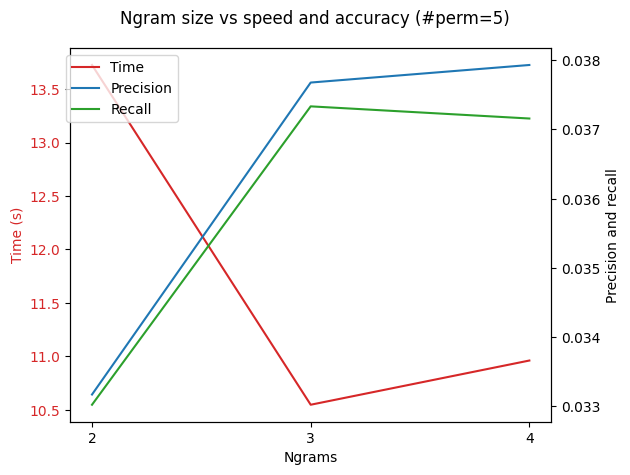

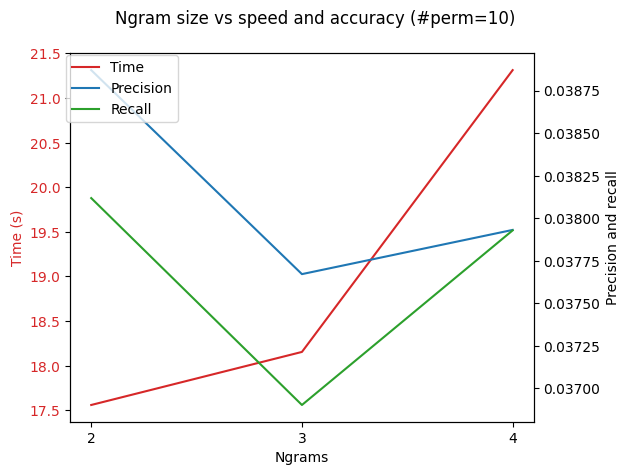

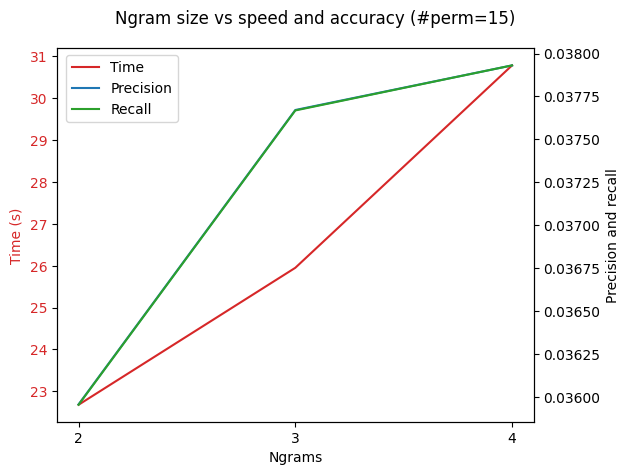

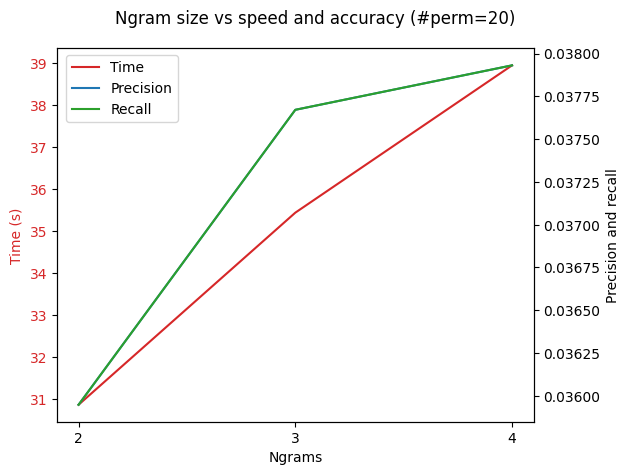

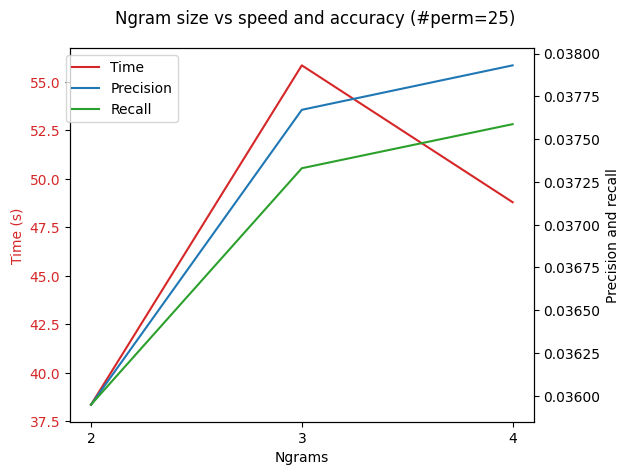

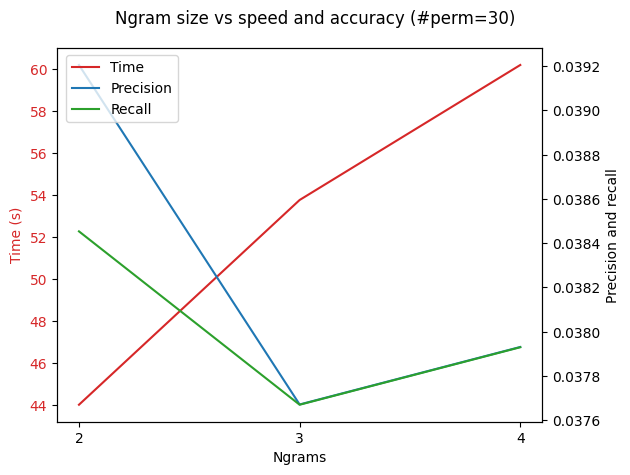

In [37]:
for i in test_num_perm:
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Ngrams')
    ax1.set_ylabel('Time (s)', color=color)
    ax1.plot(test_ngram_size, testing_time_results[:,int((i-test_num_perm[0])/step)], color=color, label='Time')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(test_ngram_size)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    ax2.set_ylabel('Precision and recall', color='black')
    ax2.plot(test_ngram_size, testing_accuracy_results_relevant[:,int((i-test_num_perm[0])/step),0], color='tab:blue', label='Precision')
    ax2.plot(test_ngram_size, testing_accuracy_results_relevant[:,int((i-test_num_perm[0])/step),1], color='tab:green', label='Recall')
    ax2.tick_params(axis='y', labelcolor='black')

    fig.suptitle(f'Ngram size vs speed and accuracy (#perm={i})')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

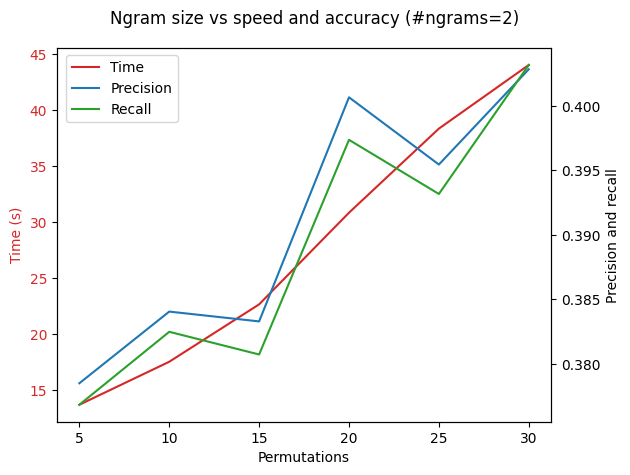

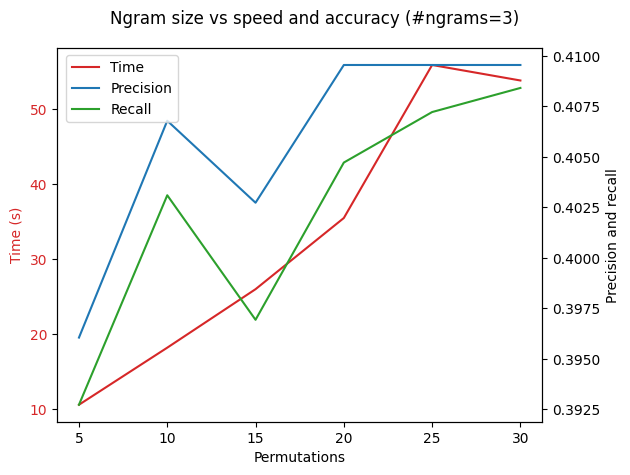

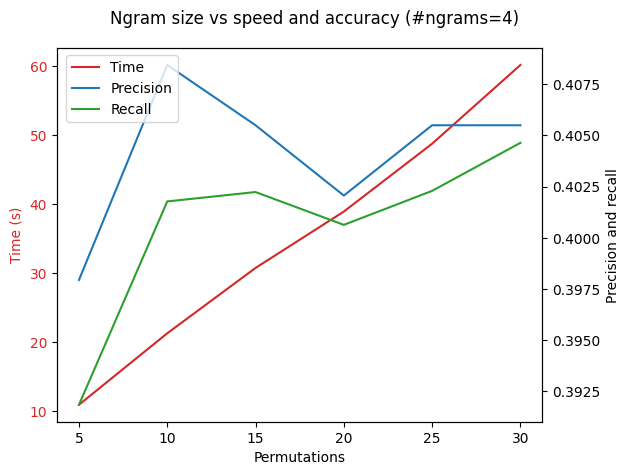

In [38]:
for i in test_ngram_size:
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Permutations')
    ax1.set_ylabel('Time (s)', color=color)
    ax1.plot(test_num_perm, testing_time_results[i-test_ngram_size[0],:], color=color, label='Time')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(test_num_perm)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    ax2.set_ylabel('Precision and recall', color='black')
    ax2.plot(test_num_perm, testing_accuracy_results_all[i-test_ngram_size[0],:,0], color='tab:blue', label='Precision')
    ax2.plot(test_num_perm, testing_accuracy_results_all[i-test_ngram_size[0],:,1], color='tab:green', label='Recall')
    ax2.tick_params(axis='y', labelcolor='black')

    fig.suptitle(f'Ngram size vs speed and accuracy (#ngrams={i})')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Conclusions

We can see in the above plots that even for a small number of permutations the increase in precision and recall increases in both cases. Ideally if the permutation count was the same as the number of ngrams, the precision and recall should end up at 1. For a fraction of the computational complexity we get a 0.04 increase in both precision and recall (looking at ngram_size=2 plot), going from 5 permutations to 30. That is quite significant taking into account the small scale of the permutations.

We can also see that the accuracy (precision and recall) seems proportional to the number of ngrams, regardless of the permutation count.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>